# Sample captions & visualize attention

In [1]:
import sys; sys.argv=['']; del sys
import numpy as np
import os
from args import get_parser
from utils.dataloader import DataLoader
from utils.config import get_opt
from utils.lang_proc import idx2word, sample, beamsearch
from model import get_model
import pickle

Using TensorFlow backend.


In [2]:
parser = get_parser()
args_dict = parser.parse_args()
args_dict.mode = 'test'
args_dict.bs = 1

Choose model weights to load:

In [3]:
args_dict.model_file = '/work/asalvador/sat_keras/models/model_weights.14-2.93.h5'

Initialize model and load weights:

In [4]:
model = get_model(args_dict)
opt = get_opt(args_dict)

weights = args_dict.model_file
model.load_weights(weights)

model.compile(optimizer=opt,loss='categorical_crossentropy')

In [5]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (1, 224, 224, 3)      0                                            
____________________________________________________________________________________________________
vgg16 (Model)                    multiple              14714688    input_2[0][0]                    
____________________________________________________________________________________________________
reshape_1 (Reshape)              (1, 49, 512)          0           vgg16[1][0]                      
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (1, 49, 512)          2048        reshape_1[0][0]                  
___________________________________________________________________________________________

Create the extractor that outputs attention weights and class probabilities

In [6]:
from keras.models import Model
att_layer = 'timedistributed_7'
extractor = Model(input=model.input,output=[model.output,model.get_layer(att_layer).output])

Load the word vocabulary to map idxs to words:

In [7]:
vocab_file = os.path.join(args_dict.data_folder,'data',args_dict.vfile)
vocab = pickle.load(open(vocab_file,'rb'))
inv_vocab = {v:k for k,v in vocab.items()}

Initialize the generator to yield samples:

In [8]:
dataloader = DataLoader(args_dict)
N = args_dict.bs
val_gen = dataloader.generator('train',batch_size=args_dict.bs,train_flag=False) # N samples

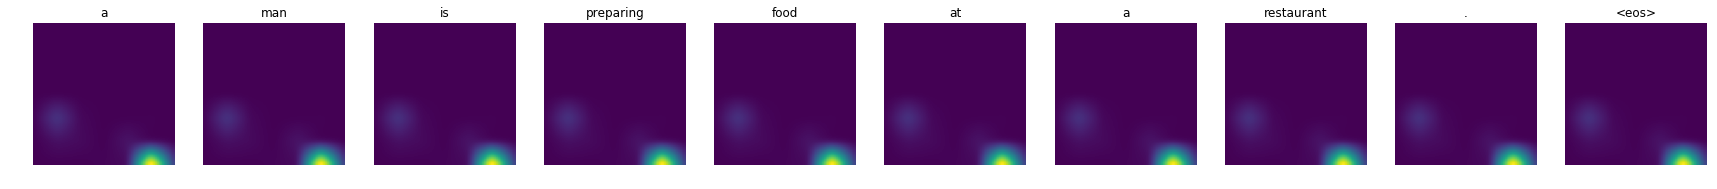

('ID:', u'COCO_train2014_000000064460.jpg')
('True:', u'a kitchen in a restaurant with food on the counter . <eos>')
('Gen:', u'a man is preparing food at a restaurant . <eos>')
----------


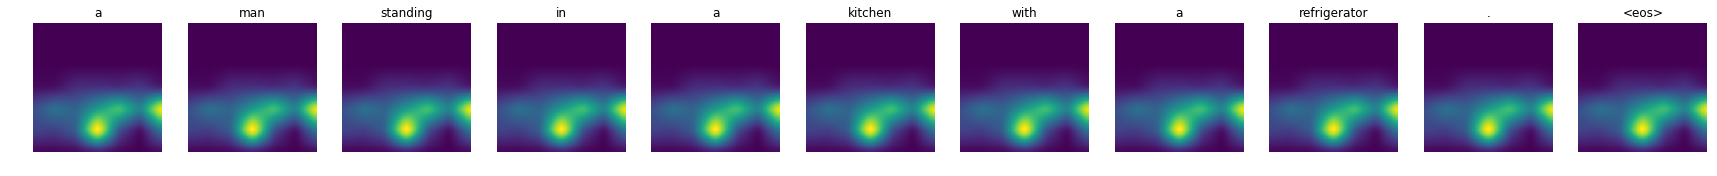

('ID:', u'COCO_train2014_000000581674.jpg')
('True:', u'several kitchen workers making dishes in commercial kitchen . <eos>')
('Gen:', u'a man standing in a kitchen with a refrigerator . <eos>')
----------


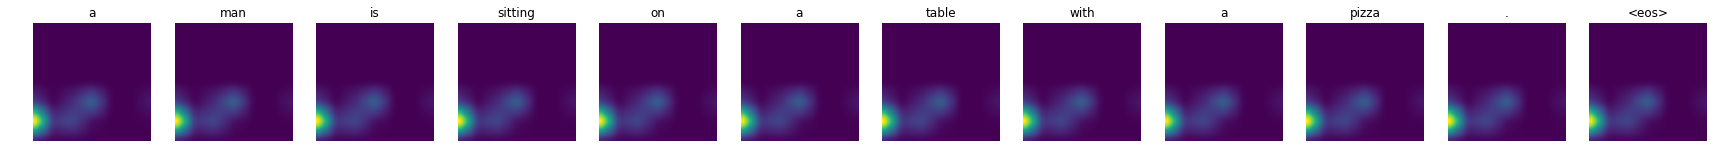

('ID:', u'COCO_train2014_000000470072.jpg')
('True:', u'a grill that has a bunch of burgers on it <eos>')
('Gen:', u'a man is sitting on a table with a pizza . <eos>')
----------


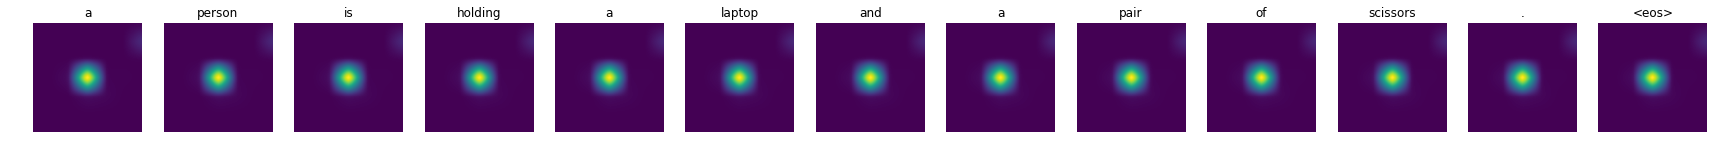

('ID:', u'COCO_train2014_000000344806.jpg')
('True:', u'a man laying on his stomach with a towel on his head . <eos>')
('Gen:', u'a person is holding a laptop and a pair of scissors . <eos>')
----------


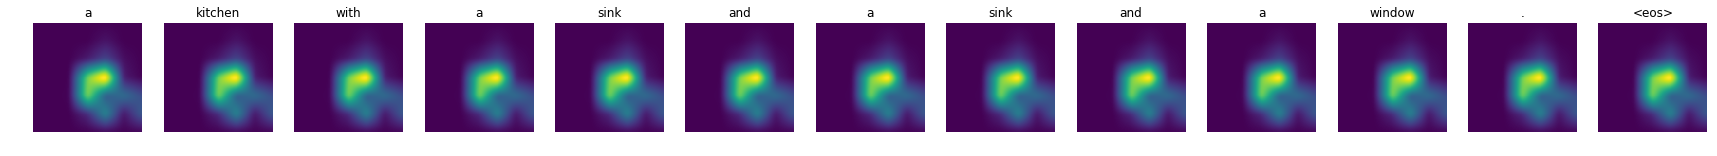

('ID:', u'COCO_train2014_000000084427.jpg')
('True:', u'a small cluttered kitchen with a window and sink . <eos>')
('Gen:', u'a kitchen with a sink and a sink and a window . <eos>')
----------


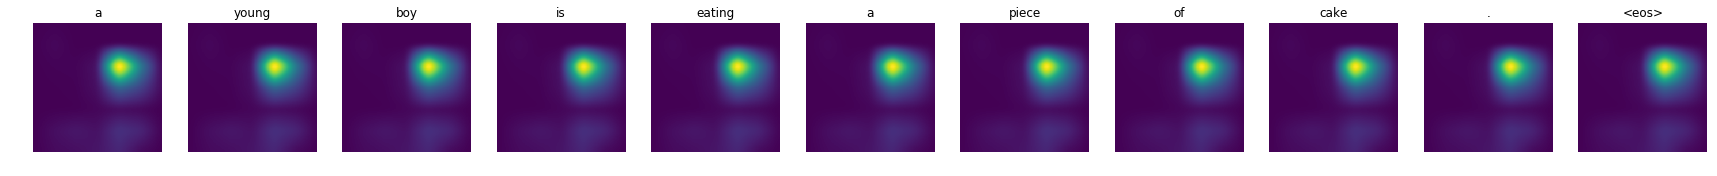

('ID:', u'COCO_train2014_000000317237.jpg')
('True:', u'a small child eating noodles from a bowl in a kitchen <eos>')
('Gen:', u'a young boy is eating a piece of cake . <eos>')
----------


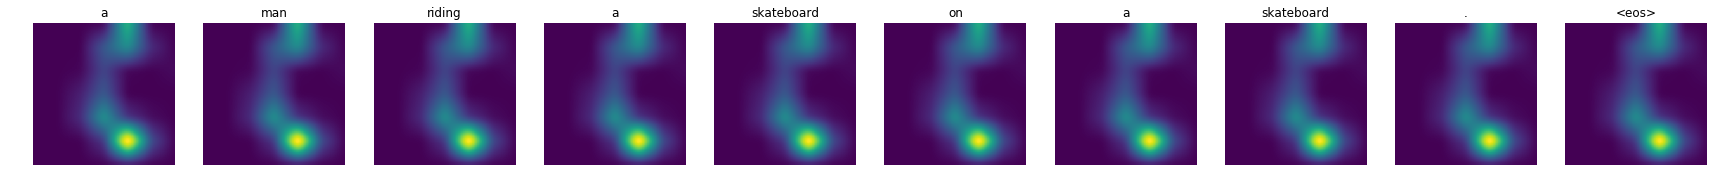

('ID:', u'COCO_train2014_000000409382.jpg')
('True:', u'people on a skateboard ramp with one doing a trick and one with skateboard on his head . <eos>')
('Gen:', u'a man riding a skateboard on a skateboard . <eos>')
----------


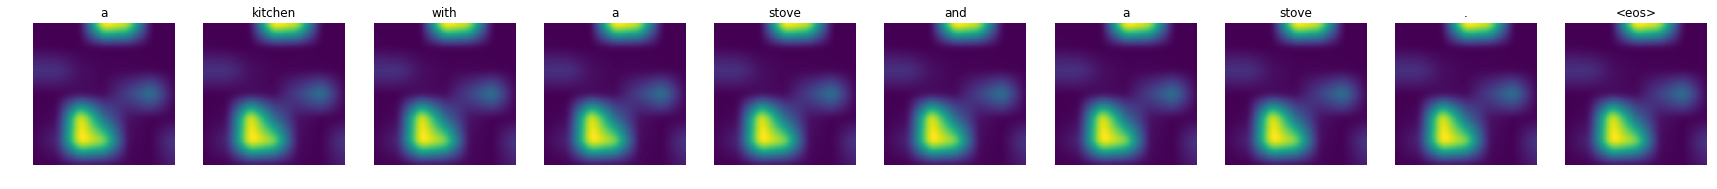

('ID:', u'COCO_train2014_000000570608.jpg')
('True:', u'a kitchen that has a microwave and some cabinets in it <eos>')
('Gen:', u'a kitchen with a stove and a stove . <eos>')
----------


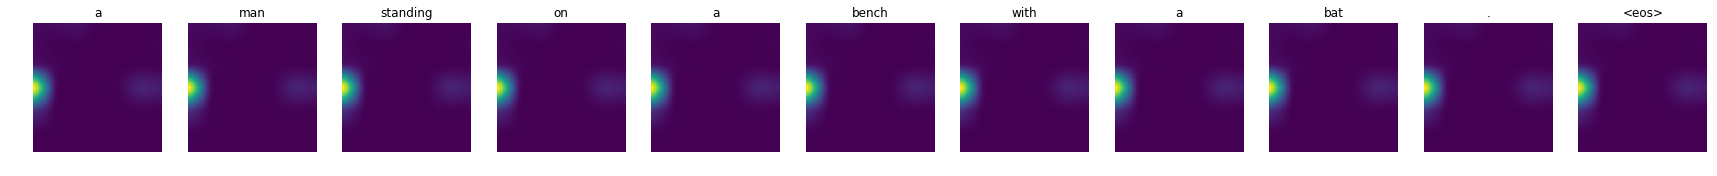

('ID:', u'COCO_train2014_000000469605.jpg')
('True:', u'there is a man standing on a field talking on the phone <eos>')
('Gen:', u'a man standing on a bench with a bat . <eos>')
----------


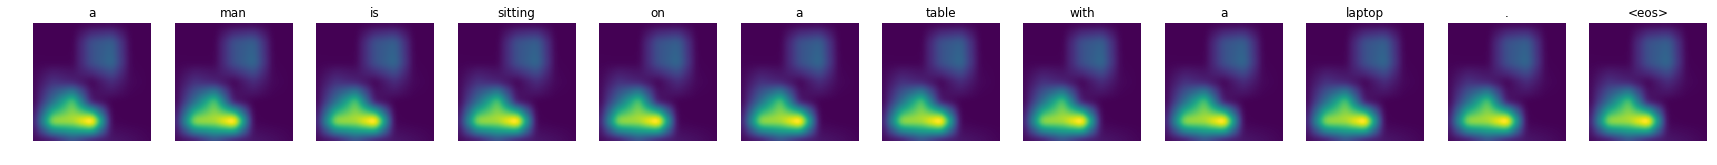

('ID:', u'COCO_train2014_000000356702.jpg')
('True:', u"a couple of young men sitting in front of a child 's laptop . <eos>")
('Gen:', u'a man is sitting on a table with a laptop . <eos>')
----------


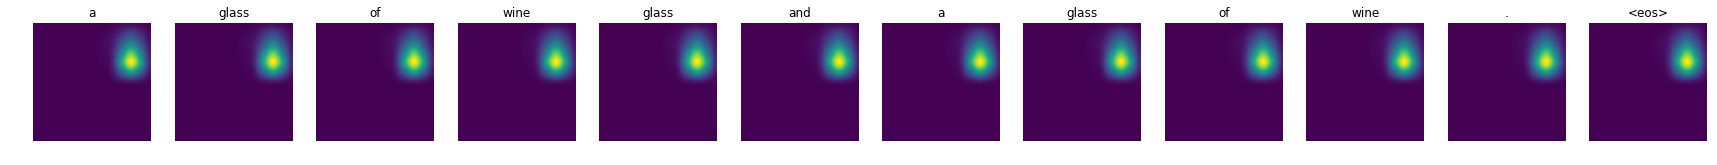

('ID:', u'COCO_train2014_000000405207.jpg')
('True:', u'a large bottle of wine sitting on a kitchen counter . <eos>')
('Gen:', u'a glass of wine glass and a glass of wine . <eos>')
----------


In [11]:
from utils.im_proc import process_image, center_crop
import matplotlib.pyplot as plt  
%matplotlib inline
import os
from scipy.ndimage.interpolation import zoom
from scipy.ndimage.filters import gaussian_filter
import copy

IMPATH = os.path.join(args_dict.coco_path,'images','train' + args_dict.year)

count = 0
sig = 5
th = 0.3
for im,cap,imids in val_gen:
    
    atts = np.zeros((args_dict.seqlen, args_dict.imsize,args_dict.imsize))
    
    prevs = np.ones((N,1))
    word_idxs = np.zeros((N,args_dict.seqlen))
    imname = imids[0]['file_name']
    
    img = process_image(os.path.join(IMPATH,imname),args_dict.resize)
    img = center_crop(img,args_dict.imsize)

    for i in range(args_dict.seqlen):
        # get predictions
        preds,att = extractor.predict([im,prevs]) #(N,1,vocab_size)
        
        s_att = np.shape(att)[-1]
        s = int(np.sqrt(s_att))
        att = np.reshape(att,(s,s))
        att = zoom(att,float(img.shape[0])/att.shape[-1],order=1)
        att = gaussian_filter(att,sigma=sig)
        atts[i] = att

        preds = preds.squeeze()

        word_idxs[:,i] = np.argmax(preds,axis=-1)
        prevs = np.argmax(preds,axis=-1)
        prevs = np.reshape(prevs,(N,1))

    pred_caps = idx2word(word_idxs,inv_vocab)
    true_caps = idx2word(np.argmax(cap,axis=-1),inv_vocab)
    
    n_words = len(pred_caps[0])
    
    f, axarr = plt.subplots(1,n_words,figsize=(30,30))
    
    for i in range(n_words):
        im = copy.deepcopy(img)
        for c in range(3):
            im[:,:,c] = im[:,:,c]*atts[i]
        axarr[i].imshow(atts[i])
        axarr[i].axis('off')
        axarr[i].set_title(pred_caps[0][i])
    
    plt.show()
    
    pred_cap = ' '.join(pred_caps[0])
    true_cap = ' '.join(true_caps[0])
    
    # true captions
    print ("ID:", imids[0]['file_name'])
    print ("True:", true_cap)
    print ("Gen:", pred_cap)
    print ("-"*10)

    model.reset_states()
    count+=1
    if count > 10:
        break